In [1]:
from matplotlib.pyplot import figure, grid, plot, show, xlabel, ylabel
from numpy import array, concatenate, cos, diag, dot, identity, linspace, pi, reshape, sin, sqrt, tensordot, zeros
from numpy.linalg import eigvalsh, inv, norm, solve

from dynamics import AffineDynamics, AffineQuadCLF, RoboticDynamics, ScalarDynamics, SystemDynamics
from controllers import FBLinController, LQRController, QPController
from attitude_utils import dcm_from_euler, elem_euler_rot, euler_to_ang, evec, ss_cross

# Satellite Attitude Control

$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

$\newcommand{\R}{\bb{R}}$

In [2]:
class Satellite(SystemDynamics, RoboticDynamics):
    def __init__(self, J, rot_order):
        SystemDynamics.__init__(self, 6, 3)
        RoboticDynamics.__init__(self, identity(3))
        self.J = J
        self.J_inv = inv(J)
        self.dcm, self.graddcm, self.hessdcm = dcm_from_euler(rot_order)
        self.T, self.grad_T = euler_to_ang(rot_order)
        
    def drift(self, x, t):
        xi, xi_dot = reshape(x, (2, 3))
        T = self.T(xi)
        omega = dot(T, xi_dot)
        return concatenate([xi_dot, -solve(T, solve(J, dot(ss_cross(omega), dot(J, omega))) - dot(tensordot(self.grad_T(xi), xi_dot, (-1, 0)), xi_dot))])
    
    def act(self, x, t):
        xi, _ = reshape(x, (2, 3))
        return concatenate([zeros((3, 3)), solve(self.T(xi), self.J_inv)])
    
J = diag([10, 10, 40])
rot_order = array([1, 2, 3])
system = Satellite(J, rot_order)

In [3]:
Q = 100 * identity(6)
R = identity(3)

lqr = LQRController.build(system, Q, R)
fb_lin = FBLinController(system, lqr)

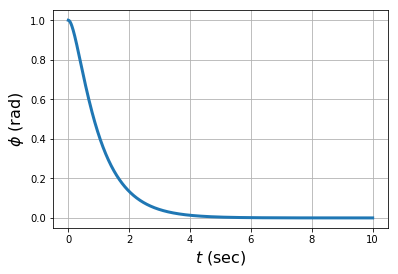

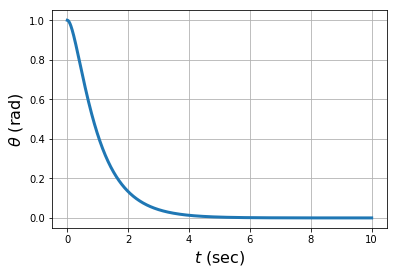

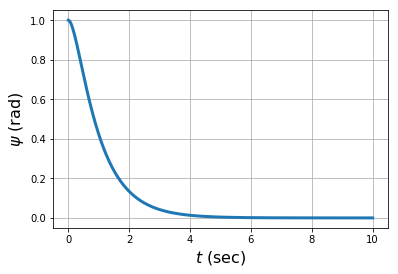

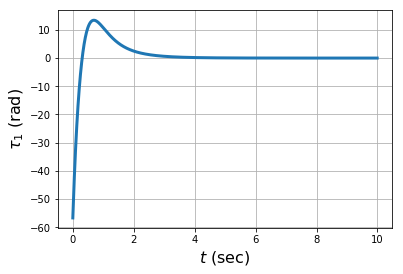

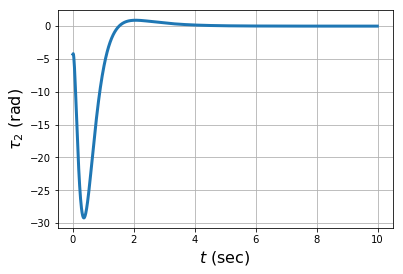

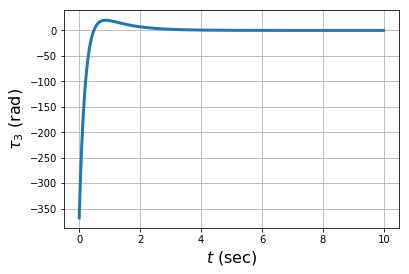

In [4]:
# Feedback Linearization Simulation & Plotting
T = 10
N = 100
ts = linspace(0, T, int(T * N) + 1)

x_0 = array([1, 1, 1, 0, 0, 0])

xs, us = system.simulate(x_0, fb_lin, ts)
us = array(us)
fb_lin_data = (xs, us)

xs, us = fb_lin_data

figure()
plot(ts, xs[:, 0], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\phi$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\theta$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\psi$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 0], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_1$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 1], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_2$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 2], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_3$ (rad)', fontsize=16)

show()

In [5]:
# QP Setup
qp = QPController(system, 3)

# Stability
lyap = AffineQuadCLF.build_care(system, Q, R)
alpha_stability = -min(eigvalsh(Q))/max(eigvalsh(lyap.P))
comp_stability = lambda r: alpha_stability * r
relax_coeff = 1e2
qp.add_stability_constraint(lyap, comp_stability, True, relax_coeff)

# Regularization
reg_coeff = 1e1
qp.add_regularizer(fb_lin, reg_coeff)

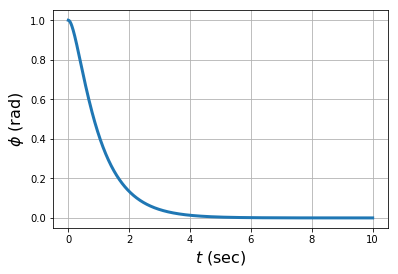

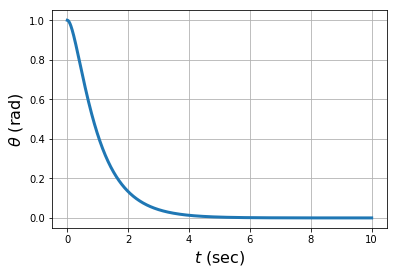

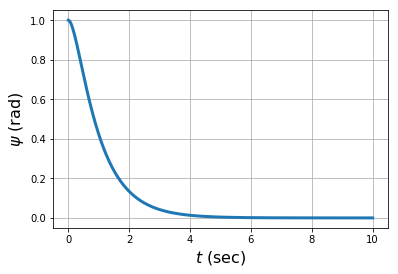

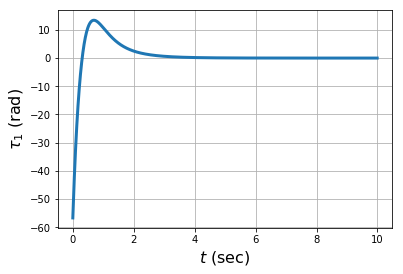

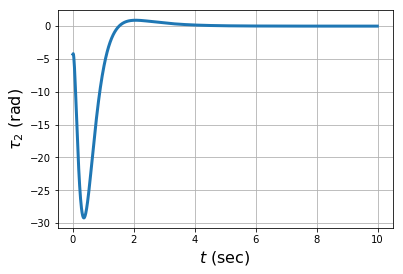

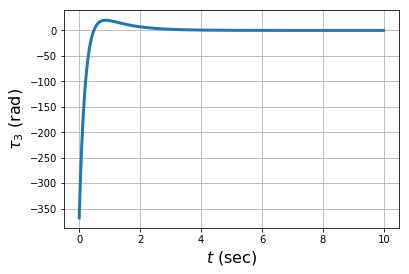

In [6]:
# QP Simulation & Plotting

xs, us = system.simulate(x_0, qp, ts)
us = array(us)
fb_lin_data = (xs, us)

xs, us = fb_lin_data

figure()
plot(ts, xs[:, 0], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\phi$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\theta$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\psi$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 0], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_1$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 1], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_2$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 2], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_3$ (rad)', fontsize=16)

show()

In [7]:
class SafetyAngVel(AffineDynamics, ScalarDynamics):
    def __init__(self, satellite, max_rate):
        self.dynamics = satellite
        self.max_rate = max_rate
        
    def eval(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        omega = dot(self.dynamics.T(q), q_dot)
        
        return 0.5 * (max_rate ** 2 - dot(omega, omega))
    
    def drift(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        omega = dot(self.dynamics.T(q), q_dot)
        J = self.dynamics.J
        J_inv = self.dynamics.J_inv
    
        return dot(omega, dot(J_inv, dot(ss_cross(omega), dot(J, omega))))
        
    def act(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        omega = dot(self.dynamics.T(q), q_dot)
        
        return -dot(omega, self.dynamics.J_inv)

## Pointing Safety Constraints

Suppose that we wish to avoid pointing a certain feature on the satellite along a certain direction in the inertial frame. We can utilize extended safety functions to encode this behavior in the quadratic program based controller. 

Let the feature on the satellite we want to avoid pointing the wrong direction be aligned along $\underrightarrow{b}^1$ vector. If not, we can utilize a static DCM to represent the pointing direction in the body frame. Let the vector we wish to avoid be described by $\underrightarrow{n}$. Safety is then encoded as:

\begin{equation}
\langle \mb{b}_b^1, \mb{C}_{bi}(\bs{\xi})\mb{n}_i\rangle = \mb{b}_b^{1^\top}\mb{C}_{bi}(\bs{\xi})\mb{n}_i = \mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i)\leq \cos(\zeta)
\end{equation}
or equivalently by the safety function:

\begin{equation}
h(\bs{\xi}) = \cos(\zeta)-\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i) 
\end{equation}

where $\zeta$ is the keepout angle. The time derivative of this safety function appears as:

\begin{equation}
\dot{h}(\bs{\xi},\dot{\bs{\xi}}) = -\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}})
\end{equation}

where $\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{e}_i,\mb{e}_j,\mb{e}_k) = \derp{(\mb{C}_{bi}(\bs{\xi}))_{ij}}{\xi_k}$. As expected for robotic systems, the input $\bs{\tau}$ does not appear in this expression, and an extended safety function is necessary to ensure safety.

Let the extended safety function $h_e$ be defined as:

\begin{align}
h_e(\bs{\xi},\dot{\bs{\xi}}) =  & \dot{h}(\bs{\xi}, \dot{\bs{\xi}}) + \alpha(h(\bs{\xi})) \\ = & -\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}}) + \alpha(\cos(\zeta)-\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i))
\end{align}

where $\alpha\in\cal{K}_e$ is differentiable. The time derivative of this extended safety function is given by:

\begin{align}
\dot{h}_e = & -\bs{\nabla}^2\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}},\dot{\bs{\xi}})-\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\ddot{\bs{\xi}})-\left.\derp{\alpha}{r}\right\vert_{h(\bs{\xi})}\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}}) \\ = & -\bs{\nabla}^2\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}},\dot{\bs{\xi}})-\left.\derp{\alpha}{r}\right\vert_{h(\bs{\xi})}\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}})-\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\ddot{\bs{\xi}})
\end{align}

Noting that $\dot{\bs{\omega}}^{bi}_b = \bs{\nabla}\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})+\mb{T}(\bs{\xi})\ddot{\bs{\xi}}$, we write $\ddot{\bs{\xi}}$ as:

\begin{equation}
\ddot{\bs{\xi}} = -\mb{T}(\bs{\xi})^{-1}(\mb{J}^{-1}\bs{\omega}_b^{bi^\times}\mb{J}\bs{\omega}_b^{bi}-\bs{\nabla}\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}}))+\mb{T}(\bs{\xi})^{-1}\mb{J}^{-1}\bs{\tau}
\end{equation}

Thus the extended safety function derivative can be written as

\begin{equation}
\dot{h}_e = -\bs{\nabla}^2\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}},\dot{\bs{\xi}})-\left.\derp{\alpha}{r}\right\vert_{h(\bs{\xi})}\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\dot{\bs{\xi}})+\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\mb{T}(\bs{\xi})^{-1}(\mb{J}^{-1}\bs{\omega}_b^{bi^\times}\mb{J}\bs{\omega}_b^{bi}+\bs{\nabla}\mb{T}(\bs{\xi})(\cdot,\dot{\bs{\xi}},\dot{\bs{\xi}})))-\bs{\nabla}\mb{C}_{bi}(\bs{\xi})(\mb{b}_b^1,\mb{n}_i,\cdot)^{\top}\mb{T}(\bs{\xi})^{-1}\mb{J}^{-1}\bs{\tau}
\end{equation}




In [8]:
class SafetyPointing(AffineDynamics, ScalarDynamics):
    def __init__(self, satellite, keepout_vec, keepout_angle, alpha):
        self.dynamics = satellite
        self.keepout_vec = keepout_vec
        self.keepout_angle = keepout_angle
        self.alpha = alpha
        
    def h(self, x, t):
        xi, _ = reshape(x, (2, -1))
        b1_b = evec(3, 0)
        
        return cos(self.keepout_angle) - dot(b1_b, dot(self.dynamics.dcm(xi), keepout_vec))
    
    def h_dot(self, x, t):
        xi, xi_dot = reshape(x, (2, -1))
        b1_b = evec(3, 0)
        
        return -dot(dot(tensordot(self.dynamics.graddcm(xi), xi_dot, (-1, 0)), self.keepout_vec), b1_b)
        
    def comp(self, r):
        return self.alpha * r
        
    def gradcomp(self, r):
        return self.alpha
        
    def eval(self, x, t):
        return self.h_dot(x, t) + self.comp(self.h(x, t))
    
    def drift(self, x, t):
        xi, xi_dot = reshape(x, (2, -1))
        b1_b = evec(3, 0)
    
        drift_1 = -dot(dot(tensordot(tensordot(self.dynamics.hessdcm(xi), xi_dot, (-1, 0)), xi_dot, (-1, 0)), self.keepout_vec), b1_b)
        drift_2 = -self.gradcomp(self.h(x, t)) * dot(dot(tensordot(self.dynamics.graddcm(xi), xi_dot, (-1, 0)), self.keepout_vec), b1_b)
        drift_3 = -dot(dot(tensordot(self.dynamics.graddcm(xi), self.dynamics.drift(x, t)[3:], (-1, 0)), self.keepout_vec), b1_b)
        
        return drift_1 + drift_2 + drift_3
        
    def act(self, x, t):
        xi, xi_dot = reshape(x, (2, -1))
        b1_b = evec(3, 0)
        
        return -dot(dot(self.keepout_vec, tensordot(self.dynamics.graddcm(xi), b1_b, (0, 0))),self.dynamics.act(x, t)[3:])

In [9]:
# QP with Safety
qp = QPController(system, 3)

# Regularization
reg_coeff = 1
qp.add_regularizer(fb_lin, reg_coeff)

# Stability
lyap = AffineQuadCLF.build_care(system, Q, R)
alpha_stability = -min(eigvalsh(Q))/max(eigvalsh(lyap.P))
comp_stability = lambda r: alpha_stability * r
relax_coeff = 1e1
qp.add_stability_constraint(lyap, comp_stability, True, relax_coeff)

# Angular Velocity Safety
# max_rate = 0.5
# safe = SafetyAngVel(system, max_rate)
# alpha_safety = 10
# comp_safety = lambda r: alpha_safety * r
# qp.add_safety_constraint(safe, comp_safety)

# Pointing Safety
keepout_vec = dot(elem_euler_rot(2, pi/4), dot(elem_euler_rot(3, pi/24), evec(3, 0)))
keepout_angle = pi/10
alpha = 20
safe = SafetyPointing(system, keepout_vec, keepout_angle, alpha)
alpha_e = 20
comp_safety = lambda r: alpha_e * r
qp.add_safety_constraint(safe, comp_safety)

In [10]:
# QP with Safety Simulation & Plotting
T = 10
N = 100
ts = linspace(0, T, int(T * N) + 1)
x_0 = array([pi/30, -7*pi/16, 0, 0, 0, 0])

qp_safe_data = system.simulate(x_0, qp, ts)
xs, us = qp_safe_data

hs = array([safe.h(x, t) for x, t in zip(xs, ts)])
hes = array([safe.eval(x, t) for x, t in zip(xs,ts)])

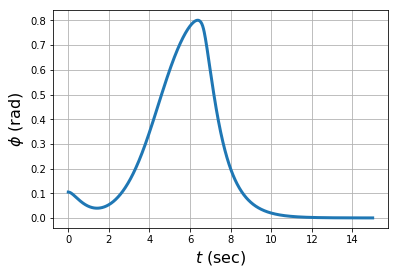

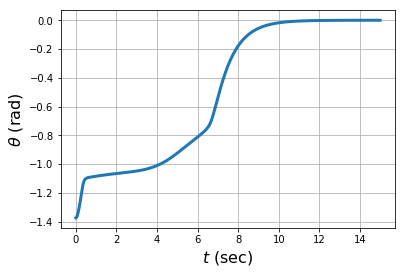

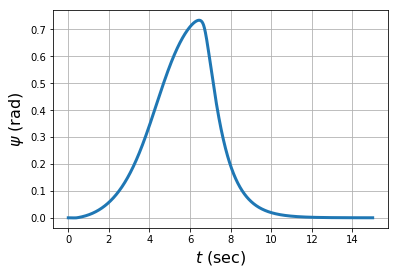

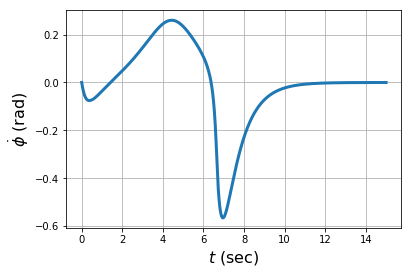

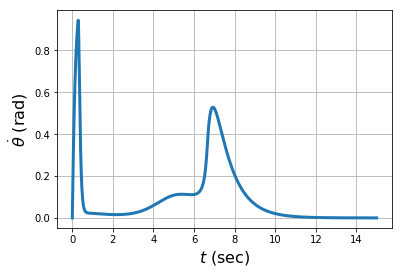

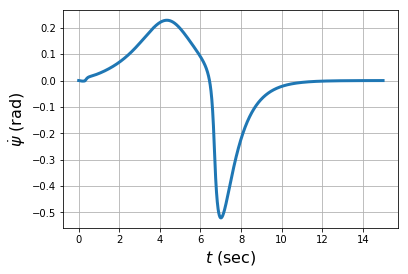

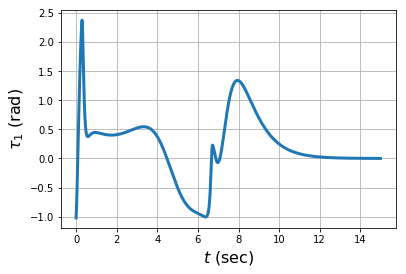

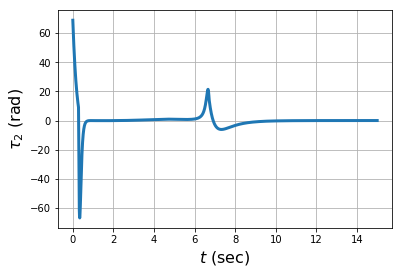

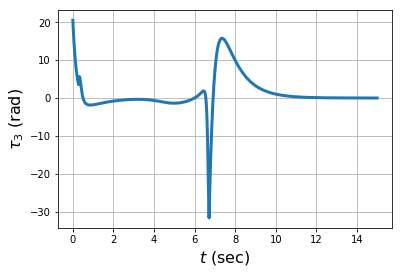

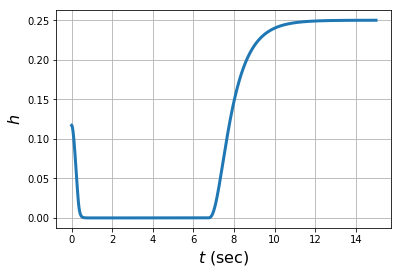

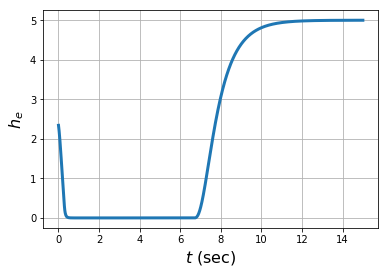

In [11]:
# Simulation Plotting

figure()
plot(ts, xs[:, 0], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\phi$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 1], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\theta$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 2], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\psi$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 3], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\dot{\\phi}$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 4], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\dot{\\theta}$ (rad)', fontsize=16)

figure()
plot(ts, xs[:, 5], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\dot{\\psi}$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 0], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_1$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 1], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_2$ (rad)', fontsize=16)

figure()
plot(ts[:-1], us[:, 2], linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$\\tau_3$ (rad)', fontsize=16)

figure()
plot(ts, hs, linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$h$', fontsize=16)

figure()
plot(ts, hes, linewidth=3)
grid()
xlabel('$t$ (sec)', fontsize=16)
ylabel('$h_e$', fontsize=16)

show()

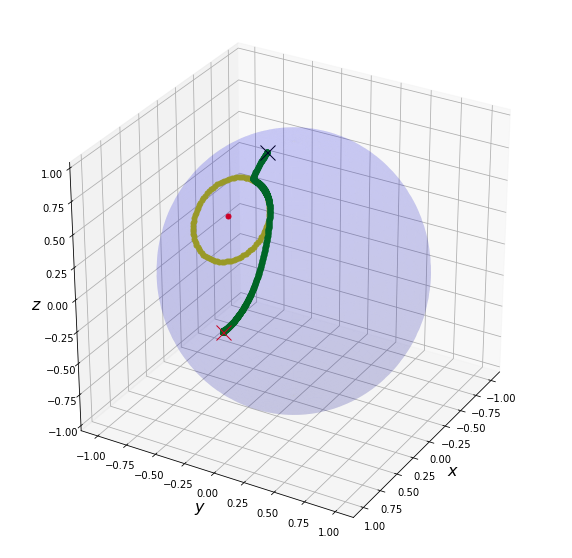

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from numpy import ones, outer, size
from attitude_utils import dcm_from_axisangle

fig = figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.elev = 30
ax.azim = 30

# Plot keepout circle
sweep_vec = dot(elem_euler_rot(2, keepout_angle), keepout_vec)
angles = linspace(0, 2 * pi, 100)
keepout_circ = array([dot(dcm_from_axisangle(keepout_vec, -angle), sweep_vec) for angle in angles])
ax.plot(keepout_circ[:, 0], keepout_circ[:, 1], keepout_circ[:, 2], 'yo', markersize = 5)
ax.plot(keepout_vec[0:1], keepout_vec[1:2], keepout_vec[2:], 'ro', markersize = 5)

# Plot trajectory
headings = array([dot(elem_euler_rot(rot_order[0], -x[0]), dot(elem_euler_rot(rot_order[1], -x[1]), dot(elem_euler_rot(rot_order[2], -x[2]), evec(3,0))))                for x in xs])
ax.plot(headings[:,0],headings[:,1],headings[:,2],'go', markersize = 5)
ax.plot([headings[0, 0]], [headings[0, 1]], [headings[0, 2]], 'kx', markersize = 15)
ax.plot([headings[-1, 0]], [headings[-1, 1]], [headings[-1, 2]], 'rx', markersize = 15)

# Plot the surface
u = linspace(0, 2 * pi, 100)
v = linspace(0, pi, 100)
x = 1 * outer(cos(u), sin(v))
y = 1 * outer(sin(u), sin(v))
z = 1 * outer(ones(size(u)), cos(v))
ax.plot_surface(x, y, z, color='b', alpha = .1)

# Labels
ax.set_xlabel('$x$', fontsize = 16)
ax.set_ylabel('$y$', fontsize = 16)
ax.set_zlabel('$z$', fontsize = 16)

show()